## –°–µ–º–∏–Ω–∞—Ä 2: –†–∞–±–æ—Ç–∞ —Å –¥–∞–Ω–Ω—ã–º–∏ –∏ —Å–æ–∑–¥–∞–Ω–∏–µ –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π


In [23]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## –ü–æ–∏—Å–∫ –æ—à–∏–±–æ–∫ –≤ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞—Ö –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π


In [18]:
# –ú–æ–¥–µ–ª—å 1
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop1(self.bn1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# model1 = CNN1()
# test_input = torch.randn(1, 3, 64, 64)
# output = model1(test_input)

In [19]:
# –ú–æ–¥–µ–ª—å 2
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


model2 = CNN2()
test_input = torch.randn(1, 3, 64, 64)
output = model2(test_input)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x32 and 64x128)

In [20]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch1 = nn.Conv2d(3, 64, 3, padding=1)
        self.branch2 = nn.Conv2d(3, 128, 5, padding=2)
        self.fc = nn.Linear(192 * 16 * 16, 10)

    def forward(self, x):
        b1 = F.relu(self.branch1(x))
        b2 = F.relu(self.branch2(x))
        out = torch.cat([b1, b2], dim=1) # dim 0 —Ä–∞–Ω—å—à–µ –±—ã–ª
        out = out.view(out.size(0), -1)
        return self.fc(out)

model3 = CNN3()
test_input = torch.randn(1, 3, 64, 64)
output = model3(test_input)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x786432 and 49152x10)

## –°–æ–∑–¥–∞–Ω–∏–µ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ DataLoader


### –ß—Ç–æ —Ç–∞–∫–æ–µ Dataset?
- **Dataset** - —ç—Ç–æ –∫–ª–∞—Å—Å, –∫–æ—Ç–æ—Ä—ã–π –∏–Ω–¥–µ–∫—Å–∏—Ä—É–µ—Ç –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –æ–¥–∏–Ω –æ–±—Ä–∞–∑–µ—Ü –¥–∞–Ω–Ω—ã—Ö
- **DataLoader** - —ç—Ç–æ –∏—Ç–µ—Ä–∞—Ç–æ—Ä, –∫–æ—Ç–æ—Ä—ã–π –≥—Ä—É–ø–ø–∏—Ä—É–µ—Ç –¥–∞–Ω–Ω—ã–µ –≤ –±–∞—Ç—á–∏ –∏ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –º–Ω–æ–≥–æ–ø—Ä–æ—Ü–µ—Å—Å–Ω—É—é –∑–∞–≥—Ä—É–∑–∫—É

### –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç–æ–¥—ã Dataset:
- `__init__()` - –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è, –∑–∞–≥—Ä—É–∑–∫–∞ –º–µ—Ç–∞–¥–∞–Ω–Ω—ã—Ö
- `__len__()` - –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Ä–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞
- `__getitem__(idx)` - –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —ç–ª–µ–º–µ–Ω—Ç –ø–æ –∏–Ω–¥–µ–∫—Å—É

** –°–æ–∑–¥–∞–¥–∏–º —Å–æ–±—Å—Ç–≤–µ–Ω–Ω—ã–π DataLoader –¥–ª—è Tiny ImageNet:**


In [21]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: –ø—É—Ç—å –¥–æ –ø–∞–ø–∫–∏ tiny-imagenet-200
        split: 'train', 'val' –∏–ª–∏ 'test'
        transform: —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # —Ç–µ—Å—Ç –±–µ–∑ –º–µ—Ç–æ–∫

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"–ö–ª–∞—Å—Å–æ–≤: {len(train_dataset.class_names)}")

Train size: 100000
Val size: 10000
–ö–ª–∞—Å—Å–æ–≤: 200


## –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö


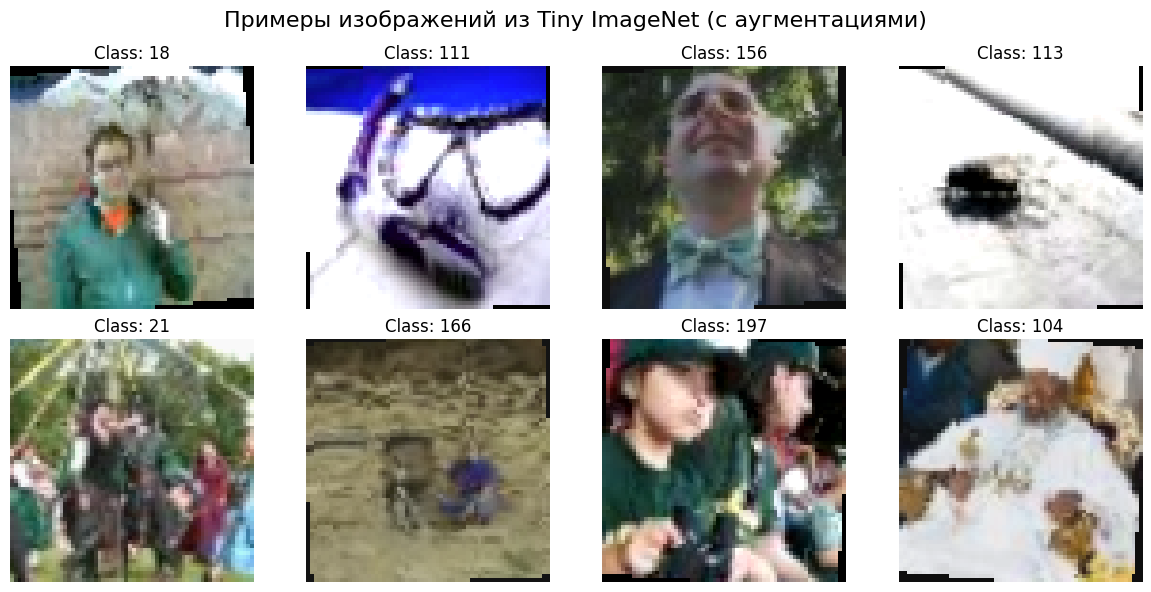

–†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞: torch.Size([8, 3, 64, 64])
–î–∏–∞–ø–∞–∑–æ–Ω –∑–Ω–∞—á–µ–Ω–∏–π: [-2.118, 2.640]
–ú–µ—Ç–∫–∏ –∫–ª–∞—Å—Å–æ–≤: [18, 111, 156, 113, 21, 166, 197, 104]
–í—Å–µ–≥–æ –∫–ª–∞—Å—Å–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: 200
–ü—Ä–∏–º–µ—Ä—ã –Ω–∞–∑–≤–∞–Ω–∏–π –∫–ª–∞—Å—Å–æ–≤: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']


In [22]:
images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu()

def denormalize(img_tensor):
    """–í–µ—Ä–Ω—ë–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏–∑ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–æ–≥–æ –¥–∏–∞–ø–∞–∑–æ–Ω–∞ –≤ [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("–ü—Ä–∏–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏–∑ Tiny ImageNet (—Å –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è–º–∏)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"–†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞: {images.shape}")
print(f"–î–∏–∞–ø–∞–∑–æ–Ω –∑–Ω–∞—á–µ–Ω–∏–π: [{images.min():.3f}, {images.max():.3f}]")
print(f"–ú–µ—Ç–∫–∏ –∫–ª–∞—Å—Å–æ–≤: {labels.tolist()}")
print(f"–í—Å–µ–≥–æ –∫–ª–∞—Å—Å–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: {len(train_dataset.class_names)}")
print(f"–ü—Ä–∏–º–µ—Ä—ã –Ω–∞–∑–≤–∞–Ω–∏–π –∫–ª–∞—Å—Å–æ–≤: {train_dataset.class_names[:5]}")

---


### –°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

### –ß—Ç–æ —Ç–∞–∫–æ–µ —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è?
**–°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è** - —ç—Ç–æ –º–µ—Ç–æ–¥ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö, –ø—Ä–∏ –∫–æ—Ç–æ—Ä–æ–º —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç—Å—è –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ –≤ –∫–∞–∂–¥–æ–π —á–∞—Å—Ç–∏.

###  –ó–∞—á–µ–º –Ω—É–∂–Ω–∞ —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è?
- –û–±–µ—Å–ø–µ—á–∏–≤–∞–µ—Ç —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ –º–µ–∂–¥—É train/val/test
- –ü—Ä–µ–¥–æ—Ç–≤—Ä–∞—â–∞–µ—Ç –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ –Ω–∞ –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏—Ö –∫–ª–∞—Å—Å–∞—Ö
- –î–∞–µ—Ç –±–æ–ª–µ–µ –Ω–∞–¥–µ–∂–Ω—É—é –æ—Ü–µ–Ω–∫—É –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–∏

###  –¢–∏–ø—ã —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏–∏:
1. **–°–ª—É—á–∞–π–Ω–∞—è —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è** - –ø—Ä–æ—Å—Ç–æ–µ —Å–ª—É—á–∞–π–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ
2. **K-Fold —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è** - —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ k —á–∞—Å—Ç–µ–π
3. **–°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º** - —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

** –†–∞—Å—Å–º–æ—Ç—Ä–∏–º —Ä–∞–∑–ª–∏—á–Ω—ã–µ –ø–æ–¥—Ö–æ–¥—ã:**


#### –ú–µ—Ç–æ–¥ 1: –ü—Ä–æ—Å—Ç–∞—è —Å–ª—É—á–∞–π–Ω–∞—è —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è


In [3]:
print(" –ú–µ—Ç–æ–¥ 1: –ü—Ä–æ—Å—Ç–∞—è —Å–ª—É—á–∞–π–Ω–∞—è —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è")

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
all_samples = train_dataset.samples

print(f" –í—Å–µ–≥–æ –æ–±—Ä–∞–∑—Ü–æ–≤: {len(all_samples)}")

random.seed(42)
all_samples_copy = all_samples.copy()
random.shuffle(all_samples_copy)

val_fraction = 0.2
split_idx = int(len(all_samples_copy) * (1 - val_fraction))
train_split_random = all_samples_copy[:split_idx]
val_split_random = all_samples_copy[split_idx:]

print(f" –°–ª—É—á–∞–π–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ:")
print(f"   Train: {len(train_split_random)} –æ–±—Ä–∞–∑—Ü–æ–≤")
print(f"   Val: {len(val_split_random)} –æ–±—Ä–∞–∑—Ü–æ–≤")

def analyze_class_distribution(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f" {name} - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:")
    print(f"   –ú–∏–Ω–∏–º—É–º: {min(class_counts.values())}")
    print(f"   –ú–∞–∫—Å–∏–º—É–º: {max(class_counts.values())}")
    print(f"   –°—Ä–µ–¥–Ω–µ–µ: {np.mean(list(class_counts.values())):.1f}")
    print(f"   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {np.std(list(class_counts.values())):.1f}")

analyze_class_distribution(train_split_random, "–°–ª—É—á–∞–π–Ω–æ–µ train")
analyze_class_distribution(val_split_random, "–°–ª—É—á–∞–π–Ω–æ–µ val")


 –ú–µ—Ç–æ–¥ 1: –ü—Ä–æ—Å—Ç–∞—è —Å–ª—É—á–∞–π–Ω–∞—è —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è
 –í—Å–µ–≥–æ –æ–±—Ä–∞–∑—Ü–æ–≤: 100000
 –°–ª—É—á–∞–π–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ:
   Train: 80000 –æ–±—Ä–∞–∑—Ü–æ–≤
   Val: 20000 –æ–±—Ä–∞–∑—Ü–æ–≤
 –°–ª—É—á–∞–π–Ω–æ–µ train - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 377
   –ú–∞–∫—Å–∏–º—É–º: 424
   –°—Ä–µ–¥–Ω–µ–µ: 400.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 9.3
 –°–ª—É—á–∞–π–Ω–æ–µ val - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 76
   –ú–∞–∫—Å–∏–º—É–º: 123
   –°—Ä–µ–¥–Ω–µ–µ: 100.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 9.3


#### –ú–µ—Ç–æ–¥ 2: C—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è —Å –ø–æ–º–æ—â—å—é sklearn


In [4]:


X = [x for x, y in all_samples]  # –ø—É—Ç–∏ –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º
y = [y for x, y in all_samples]  # –º–µ—Ç–∫–∏ –∫–ª–∞—Å—Å–æ–≤

print(f" –ü–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–æ {len(X)} –æ–±—Ä–∞–∑—Ü–æ–≤ —Å {len(set(y))} –∫–ª–∞—Å—Å–∞–º–∏")

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# –°–æ–∑–¥–∞–µ–º —Å—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è
train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ:")
print(f"   Train: {len(train_split_stratified)} –æ–±—Ä–∞–∑—Ü–æ–≤")
print(f"   Val: {len(val_split_stratified)} –æ–±—Ä–∞–∑—Ü–æ–≤")

# –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤
analyze_class_distribution(train_split_stratified, "–°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ train")
analyze_class_distribution(val_split_stratified, "–°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ val")


 –ü–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–æ 100000 –æ–±—Ä–∞–∑—Ü–æ–≤ —Å 200 –∫–ª–∞—Å—Å–∞–º–∏
 –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ:
   Train: 80000 –æ–±—Ä–∞–∑—Ü–æ–≤
   Val: 20000 –æ–±—Ä–∞–∑—Ü–æ–≤
 –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ train - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 400
   –ú–∞–∫—Å–∏–º—É–º: 400
   –°—Ä–µ–¥–Ω–µ–µ: 400.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 0.0
 –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ val - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 100
   –ú–∞–∫—Å–∏–º—É–º: 100
   –°—Ä–µ–¥–Ω–µ–µ: 100.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 0.0


#### –ú–µ—Ç–æ–¥ 3: K-Fold —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è


In [5]:
# K-Fold —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

print(f" –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ {k} —Ñ–æ–ª–¥–æ–≤:")
fold_splits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_split = [all_samples[i] for i in train_idx]
    val_split = [all_samples[i] for i in val_idx]
    fold_splits.append((train_split, val_split))
    print(f"   Fold {fold}: train={len(train_split)}, val={len(val_split)}")

print(f" –ê–Ω–∞–ª–∏–∑ –ø–µ—Ä–≤–æ–≥–æ —Ñ–æ–ª–¥–∞:")
analyze_class_distribution(fold_splits[0][0], "Fold 0 train")
analyze_class_distribution(fold_splits[0][1], "Fold 0 val")


 –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ 5 —Ñ–æ–ª–¥–æ–≤:
   Fold 0: train=80000, val=20000
   Fold 1: train=80000, val=20000
   Fold 2: train=80000, val=20000
   Fold 3: train=80000, val=20000
   Fold 4: train=80000, val=20000
 –ê–Ω–∞–ª–∏–∑ –ø–µ—Ä–≤–æ–≥–æ —Ñ–æ–ª–¥–∞:
 Fold 0 train - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 400
   –ú–∞–∫—Å–∏–º—É–º: 400
   –°—Ä–µ–¥–Ω–µ–µ: 400.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 0.0
 Fold 0 val - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
   –ú–∏–Ω–∏–º—É–º: 100
   –ú–∞–∫—Å–∏–º—É–º: 100
   –°—Ä–µ–¥–Ω–µ–µ: 100.0
   –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 0.0


## –°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è —á–µ—Ä–µ–∑ —ç–º–±–µ–¥–∏–Ω–≥–∏

## –ß—Ç–æ —Ç–∞–∫–æ–µ —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è —á–µ—Ä–µ–∑ —ç–º–±–µ–¥–∏–Ω–≥–∏?
–í–º–µ—Å—Ç–æ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –ø–æ –∫–ª–∞—Å—Å–∞–º, –º—ã –º–æ–∂–µ–º —Ä–∞–∑–¥–µ–ª–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –ø–æ **—Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º** (—ç–º–±–µ–¥–∏–Ω–≥–∞–º), –∏–∑–≤–ª–µ—á–µ–Ω–Ω—ã–º –∏–∑ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π.

### –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞:
- –£—á–∏—Ç—ã–≤–∞–µ—Ç –≤–∏–∑—É–∞–ª—å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
- –ú–æ–∂–µ—Ç –Ω–∞–π—Ç–∏ —Å–∫—Ä—ã—Ç—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –≤ –¥–∞–Ω–Ω—ã—Ö
- –ü–æ–ª–µ–∑–Ω–æ –∫–æ–≥–¥–∞ –∫–ª–∞—Å—Å—ã –Ω–µ–æ–¥–Ω–æ—Ä–æ–¥–Ω—ã –≤–Ω—É—Ç—Ä–∏ —Å–µ–±—è

### –ê–ª–≥–æ—Ä–∏—Ç–º:
1. –ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ —Å –ø–æ–º–æ—â—å—é –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏
2. –ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ (K-means)
3. –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º


### –®–∞–≥ 1: –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ–¥–≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏

–î–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏ –≤–æ–∑—å–º–µ–º —Ç–æ–ª—å–∫–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–æ–≤, —á—Ç–æ–±—ã —É—Å–∫–æ—Ä–∏—Ç—å –ø—Ä–æ—Ü–µ—Å—Å:


In [6]:

selected_classes = [0, 5, 10, 15, 20]  # 5 –∫–ª–∞—Å—Å–æ–≤
subset_samples = [s for s in train_dataset.samples if s[1] in selected_classes]

print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º {len(subset_samples)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏–∑ {len(selected_classes)} –∫–ª–∞—Å—Å–æ–≤")
print(f"–í—ã–±—Ä–∞–Ω–Ω—ã–µ –∫–ª–∞—Å—Å—ã: {selected_classes}")

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_subset_dataset = CustomDataset(subset_samples, transform=train_transform)
subset_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=False)

print(f"–°–æ–∑–¥–∞–Ω –¥–∞—Ç–∞—Å–µ—Ç —Å {len(train_subset_dataset)} –æ–±—Ä–∞–∑—Ü–∞–º–∏")


–ò—Å–ø–æ–ª—å–∑—É–µ–º 2500 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏–∑ 5 –∫–ª–∞—Å—Å–æ–≤
–í—ã–±—Ä–∞–Ω–Ω—ã–µ –∫–ª–∞—Å—Å—ã: [0, 5, 10, 15, 20]
–°–æ–∑–¥–∞–Ω –¥–∞—Ç–∞—Å–µ—Ç —Å 2500 –æ–±—Ä–∞–∑—Ü–∞–º–∏


### –®–∞–≥ 2: –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤


In [7]:
print("üß† –ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üñ•Ô∏è –ò—Å–ø–æ–ª—å–∑—É–µ–º —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {device}")

resnet = models.resnet50(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

# –°–æ–∑–¥–∞–µ–º feature extractor (—É–±–∏—Ä–∞–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–π —Å–ª–æ–π)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)

def extract_embeddings(images):
    """
    –ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ –∏–∑ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
    images: –±–∞—Ç—á [B, 3, H, W]
    """
    with torch.no_grad():
        x = feature_extractor(images)  # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)      # [B, 2048]
    return x

# –ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ –¥–ª—è –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
all_embeddings = []
all_labels = []

print("–ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ –¥–ª—è –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π...")
for images, labels in tqdm(subset_loader, desc="–ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤"):
    images = images.to(device)
    emb = extract_embeddings(images)  # [B, 2048]
    all_embeddings.append(emb.cpu())
    all_labels.append(labels)

all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

print(f"–ò–∑–≤–ª–µ—á–µ–Ω–æ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤: {all_embeddings.shape}")
print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —ç–º–±–µ–¥–∏–Ω–≥–∞: {all_embeddings.shape[1]}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–µ—Ç–æ–∫: {len(all_labels)}")


üß† –ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏...
üñ•Ô∏è –ò—Å–ø–æ–ª—å–∑—É–µ–º —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: cpu


c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


–ò–∑–≤–ª–µ–∫–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ –¥–ª—è –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π...


–ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:40<00:00,  1.01s/it]

–ò–∑–≤–ª–µ—á–µ–Ω–æ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤: (2500, 2048)
–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —ç–º–±–µ–¥–∏–Ω–≥–∞: 2048
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–µ—Ç–æ–∫: 2500


### –®–∞–≥ 3: K-means –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è


In [8]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

pseudo_labels = kmeans.fit_predict(all_embeddings)

print(f"–°–æ–∑–¥–∞–Ω–æ {n_clusters} –∫–ª–∞—Å—Ç–µ—Ä–æ–≤")
print(f"–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º: {Counter(pseudo_labels)}")

# –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –∏ –∏—Å—Ö–æ–¥–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤
cluster_class_mapping = {}
for cluster_id in range(n_clusters):
    cluster_indices = np.where(pseudo_labels == cluster_id)[0]
    cluster_classes = all_labels[cluster_indices]
    most_common_class = Counter(cluster_classes).most_common(1)[0]
    cluster_class_mapping[cluster_id] = most_common_class
    print(f"üìä –ö–ª–∞—Å—Ç–µ—Ä {cluster_id}: {len(cluster_indices)} –æ–±—Ä–∞–∑—Ü–æ–≤, "
          f"–¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å {most_common_class[0]} ({most_common_class[1]} –æ–±—Ä–∞–∑—Ü–æ–≤)")


–°–æ–∑–¥–∞–Ω–æ 10 –∫–ª–∞—Å—Ç–µ—Ä–æ–≤
–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º: Counter({np.int32(9): 675, np.int32(0): 507, np.int32(7): 322, np.int32(8): 310, np.int32(2): 158, np.int32(3): 151, np.int32(4): 135, np.int32(5): 107, np.int32(1): 82, np.int32(6): 53})
üìä –ö–ª–∞—Å—Ç–µ—Ä 0: 507 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 5 (338 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 1: 82 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 20 (80 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 2: 158 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 10 (140 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 3: 151 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 0 (141 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 4: 135 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 15 (134 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 5: 107 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 5 (86 –æ–±—Ä–∞–∑—Ü–æ–≤)
üìä –ö–ª–∞—Å—Ç–µ—Ä 6: 53 –æ–±—Ä–∞–∑—Ü–æ–≤, –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –∫–ª–∞—Å—Å 0 (53 –

### –®–∞–≥ 4: –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ —Å –ø–æ–º–æ—â—å—é PCA


PCA –æ–±—ä—è—Å–Ω—è–µ—Ç 0.174 –¥–∏—Å–ø–µ—Ä—Å–∏–∏
–ö–æ–º–ø–æ–Ω–µ–Ω—Ç–∞ 1: 0.099
–ö–æ–º–ø–æ–Ω–µ–Ω—Ç–∞ 2: 0.075


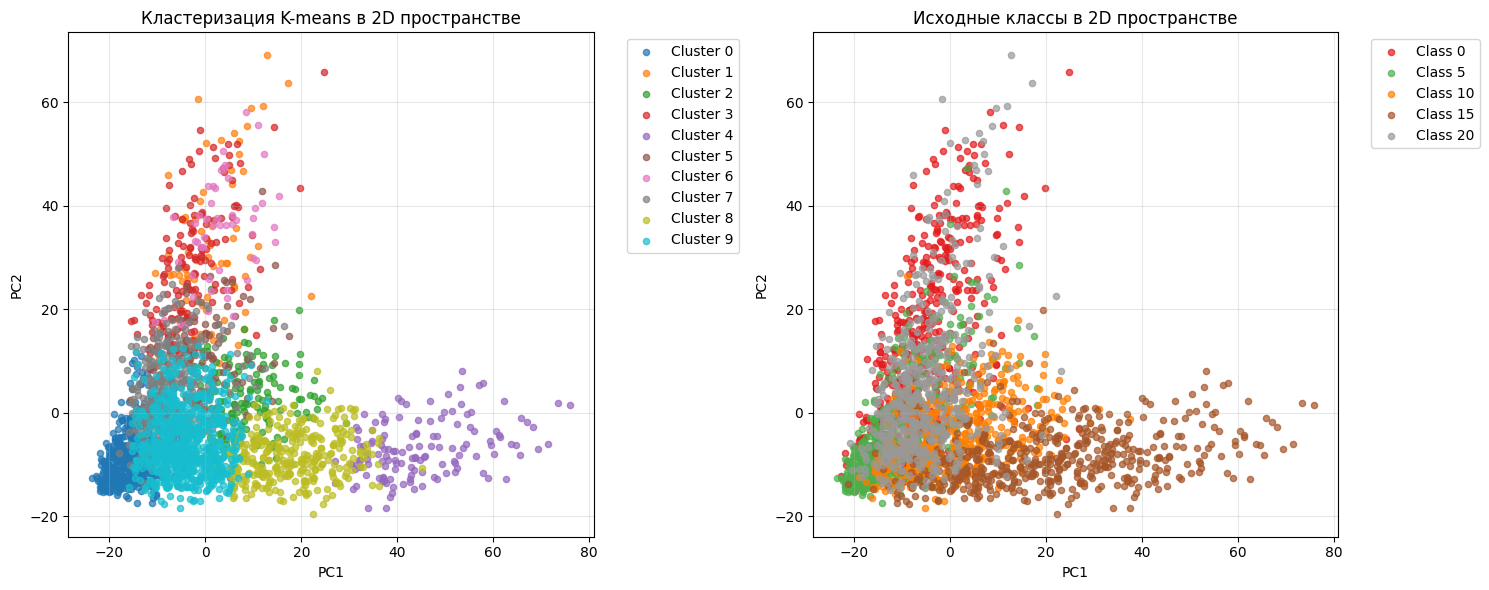

–ê–Ω–∞–ª–∏–∑ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏:
Adjusted Rand Index: 0.236
Normalized Mutual Information: 0.379
–ß–µ–º –≤—ã—à–µ –∑–Ω–∞—á–µ–Ω–∏—è, —Ç–µ–º –ª—É—á—à–µ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∏—Å—Ö–æ–¥–Ω—ã–º –∫–ª–∞—Å—Å–∞–º


In [9]:

# –ü—Ä–∏–º–µ–Ω—è–µ–º PCA –¥–ª—è —Å–Ω–∏–∂–µ–Ω–∏—è —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ –¥–æ 2D
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(all_embeddings)

print(f"PCA –æ–±—ä—è—Å–Ω—è–µ—Ç {pca.explained_variance_ratio_.sum():.3f} –¥–∏—Å–ø–µ—Ä—Å–∏–∏")
print(f"–ö–æ–º–ø–æ–Ω–µ–Ω—Ç–∞ 1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"–ö–æ–º–ø–æ–Ω–µ–Ω—Ç–∞ 2: {pca.explained_variance_ratio_[1]:.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster in range(n_clusters):
    indices = np.where(pseudo_labels == cluster)[0]
    ax1.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
               c=[colors[cluster]], label=f'Cluster {cluster}', s=20, alpha=0.7)

ax1.set_title("–ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è K-means –≤ 2D –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ –∏—Å—Ö–æ–¥–Ω—ã–º –∫–ª–∞—Å—Å–∞–º
class_colors = plt.cm.Set1(np.linspace(0, 1, len(selected_classes)))
for i, class_id in enumerate(selected_classes):
    indices = np.where(all_labels == class_id)[0]
    ax2.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
               c=[class_colors[i]], label=f'Class {class_id}', s=20, alpha=0.7)

ax2.set_title("–ò—Å—Ö–æ–¥–Ω—ã–µ –∫–ª–∞—Å—Å—ã –≤ 2D –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("–ê–Ω–∞–ª–∏–∑ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏:")
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_score = adjusted_rand_score(all_labels, pseudo_labels)
nmi_score = normalized_mutual_info_score(all_labels, pseudo_labels)

print(f"Adjusted Rand Index: {ari_score:.3f}")
print(f"Normalized Mutual Information: {nmi_score:.3f}")
print("–ß–µ–º –≤—ã—à–µ –∑–Ω–∞—á–µ–Ω–∏—è, —Ç–µ–º –ª—É—á—à–µ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∏—Å—Ö–æ–¥–Ω—ã–º –∫–ª–∞—Å—Å–∞–º")


### –®–∞–≥ 5: –°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º

–¢–µ–ø–µ—Ä—å —Ä–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ train/val –∏—Å–ø–æ–ª—å–∑—É—è –∫–ª–∞—Å—Ç–µ—Ä—ã –≤–º–µ—Å—Ç–æ –∏—Å—Ö–æ–¥–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤:


In [10]:
print("–°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º...")

sss_embedding = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_embedding, val_idx_embedding = next(sss_embedding.split(subset_samples, pseudo_labels))

train_samples_embedding = [subset_samples[i] for i in train_idx_embedding]
val_samples_embedding = [subset_samples[i] for i in val_idx_embedding]

print(f" –°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º:")
print(f"   Train: {len(train_samples_embedding)} –æ–±—Ä–∞–∑—Ü–æ–≤")
print(f"   Val: {len(val_samples_embedding)} –æ–±—Ä–∞–∑—Ü–æ–≤")

def analyze_embedding_split(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f"üìä {name} - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤:")
    for class_id in selected_classes:
        count = class_counts.get(class_id, 0)
        percentage = count / len(labels) * 100
        print(f"   –ö–ª–∞—Å—Å {class_id}: {count} –æ–±—Ä–∞–∑—Ü–æ–≤ ({percentage:.1f}%)")

analyze_embedding_split(train_samples_embedding, "Train (–ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º)")
analyze_embedding_split(val_samples_embedding, "Val (–ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º)")


–°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º...
 –°—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º:
   Train: 2000 –æ–±—Ä–∞–∑—Ü–æ–≤
   Val: 500 –æ–±—Ä–∞–∑—Ü–æ–≤
üìä Train (–ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º) - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤:
   –ö–ª–∞—Å—Å 0: 405 –æ–±—Ä–∞–∑—Ü–æ–≤ (20.2%)
   –ö–ª–∞—Å—Å 5: 397 –æ–±—Ä–∞–∑—Ü–æ–≤ (19.9%)
   –ö–ª–∞—Å—Å 10: 398 –æ–±—Ä–∞–∑—Ü–æ–≤ (19.9%)
   –ö–ª–∞—Å—Å 15: 406 –æ–±—Ä–∞–∑—Ü–æ–≤ (20.3%)
   –ö–ª–∞—Å—Å 20: 394 –æ–±—Ä–∞–∑—Ü–æ–≤ (19.7%)
üìä Val (–ø–æ —ç–º–±–µ–¥–∏–Ω–≥–∞–º) - —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤:
   –ö–ª–∞—Å—Å 0: 95 –æ–±—Ä–∞–∑—Ü–æ–≤ (19.0%)
   –ö–ª–∞—Å—Å 5: 103 –æ–±—Ä–∞–∑—Ü–æ–≤ (20.6%)
   –ö–ª–∞—Å—Å 10: 102 –æ–±—Ä–∞–∑—Ü–æ–≤ (20.4%)
   –ö–ª–∞—Å—Å 15: 94 –æ–±—Ä–∞–∑—Ü–æ–≤ (18.8%)
   –ö–ª–∞—Å—Å 20: 106 –æ–±—Ä–∞–∑—Ü–æ–≤ (21.2%)


---

## –ß–∞—Å—Ç—å 5: DataLoader —Å OpenCV –∏ Albumentations

### –ó–∞—á–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å OpenCV?
- **–ë—ã—Å—Ç—Ä–µ–µ** —á–µ–º PIL –¥–ª—è –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –æ–ø–µ—Ä–∞—Ü–∏–π
- **–ë–æ–ª—å—à–µ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–µ–π** –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π
- **–õ—É—á—à–∞—è –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏—è** —Å –±–∏–±–ª–∏–æ—Ç–µ–∫–æ–π Albumentations
- **–ü–æ–¥–¥–µ—Ä–∂–∫–∞** —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Ñ–æ—Ä–º–∞—Ç–æ–≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π

####  –ß—Ç–æ —Ç–∞–∫–æ–µ Albumentations?
- –°–æ–≤—Ä–µ–º–µ–Ω–Ω–∞—è –±–∏–±–ª–∏–æ—Ç–µ–∫–∞ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π
- –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–∞ –¥–ª—è –∫–æ–º–ø—å—é—Ç–µ—Ä–Ω–æ–≥–æ –∑—Ä–µ–Ω–∏—è
- –ü–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ—Ç –∫–∞–∫ PIL, —Ç–∞–∫ –∏ OpenCV
- –ü—Ä–æ—Å—Ç–æ–π –∏ –≥–∏–±–∫–∏–π API

** –°–æ–∑–¥–∞–¥–∏–º DataLoader —Å OpenCV –∏ Albumentations:**


In [11]:
class TinyImageNetAlbumentationsDataset(Dataset):
    """
    –î–∞—Ç–∞—Å–µ—Ç Tiny ImageNet —Å OpenCV + Albumentations
    
    –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞:
    - –ë—ã—Å—Ç—Ä–∞—è –∑–∞–≥—Ä—É–∑–∫–∞ —á–µ—Ä–µ–∑ OpenCV
    - –ú–æ—â–Ω—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ —á–µ—Ä–µ–∑ Albumentations
    - –ü–æ–¥–¥–µ—Ä–∂–∫–∞ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Ñ–æ—Ä–º–∞—Ç–æ–≤
    """
    def __init__(self, root_dir, split='train', augmentation=None):
        self.root_dir = root_dir
        self.split = split
        self.augmentation = augmentation

        # –ó–∞–≥—Ä—É–∂–∞–µ–º –Ω–∞–∑–≤–∞–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        
        print(f"üìä –ù–∞–π–¥–µ–Ω–æ {len(self.class_names)} –∫–ª–∞—Å—Å–æ–≤")

        # –°–æ–±–∏—Ä–∞–µ–º –¥–∞–Ω–Ω—ã–µ
        self.samples = self._make_dataset()
        print(f"üìÅ –ó–∞–≥—Ä—É–∂–µ–Ω–æ {len(self.samples)} –æ–±—Ä–∞–∑—Ü–æ–≤ –¥–ª—è {self.split}")

    def _make_dataset(self):
        """–°–æ–∑–¥–∞–µ–º —Å–ø–∏—Å–æ–∫ –æ–±—Ä–∞–∑—Ü–æ–≤ –¥–∞–Ω–Ω—ã—Ö"""
        data = []

        if self.split == 'train':
            data = self._load_train_data()
        elif self.split == 'val':
            data = self._load_val_data()
        elif self.split == 'test':
            data = self._load_test_data()
        else:
            raise ValueError(f"Unknown split: {self.split}")

        return data

    def _load_train_data(self):
        """–ó–∞–≥—Ä—É–∂–∞–µ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ"""
        data = []
        train_dir = os.path.join(self.root_dir, 'train')
        for cls_name in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, cls_name, 'images')
            if not os.path.isdir(img_dir):
                continue
            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img_name)
                label = self.class_to_idx[cls_name]
                data.append((img_path, label))
        return data

    def _load_val_data(self):
        """–ó–∞–≥—Ä—É–∂–∞–µ–º –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ"""
        data = []
        val_dir = os.path.join(self.root_dir, 'val')
        img_dir = os.path.join(val_dir, 'images')
        anno_file = os.path.join(val_dir, 'val_annotations.txt')

        label_map = {}
        with open(anno_file, 'r') as f:
            for line in f.readlines():
                img_name, cls_name, *_ = line.strip().split('\t')
                label_map[img_name] = self.class_to_idx[cls_name]

        for img_name in os.listdir(img_dir):
            if img_name in label_map:
                img_path = os.path.join(img_dir, img_name)
                label = label_map[img_name]
                data.append((img_path, label))
        return data

    def _load_test_data(self):
        """–ó–∞–≥—Ä—É–∂–∞–µ–º —Ç–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ"""
        data = []
        test_dir = os.path.join(self.root_dir, 'test', 'images')
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            data.append((img_path, -1))  # –Ω–µ—Ç –º–µ—Ç–æ–∫
        return data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """–í–æ–∑–≤—Ä–∞—â–∞–µ–º –æ–±—Ä–∞–∑–µ—Ü –ø–æ –∏–Ω–¥–µ–∫—Å—É"""
        img_path, label = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB


        # –ü—Ä–∏–º–µ–Ω—è–µ–º –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
        if self.augmentation:
            augmented = self.augmentation(image=img)
            img = augmented['image']

        return img, label


### –°–æ–∑–¥–∞–Ω–∏–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π —Å –ø–æ–º–æ—â—å—é Albumentations


In [ ]:
# –°–æ–∑–¥–∞–µ–º –º–æ—â–Ω—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ —Å –ø–æ–º–æ—â—å—é Albumentations

train_aug = A.Compose([
    # –ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ä–∞–∑–º–µ—Ä–∞
    A.Resize(72, 72),
    A.RandomResizedCrop(64, 64, scale=(0.8, 1.0)),
    
    # –ì–µ–æ–º–µ—Ç—Ä–∏—á–µ—Å–∫–∏–µ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–∏
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    
    # –¶–≤–µ—Ç–æ–≤—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    
    # –®—É–º –∏ —Ä–∞–∑–º—ã—Ç–∏–µ
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    
    # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ —Ç–µ–Ω–∑–æ—Ä
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# –í–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ (—Ç–æ–ª—å–∫–æ –±–∞–∑–æ–≤—ã–µ)
val_aug = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



train_dataset_cv = TinyImageNetAlbumentationsDataset(
    root_dir="data/tiny-imagenet-200",
    split="train",
    augmentation=train_aug
)

val_dataset_cv = TinyImageNetAlbumentationsDataset(
    root_dir="data/tiny-imagenet-200",
    split="val",
    augmentation=val_aug
)

train_loader_cv = DataLoader(train_dataset_cv, batch_size=8, shuffle=True, num_workers=2)
val_loader_cv = DataLoader(val_dataset_cv, batch_size=8, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset_cv)}")
print(f"Val size: {len(val_dataset_cv)}")

print("–¢–µ—Å—Ç–∏—Ä—É–µ–º OpenCV DataLoader...")
images_cv, labels_cv = next(iter(train_loader_cv))

print(f"–†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞: {images_cv.shape}")
print(f"–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {images_cv.dtype}")
print(f"–î–∏–∞–ø–∞–∑–æ–Ω –∑–Ω–∞—á–µ–Ω–∏–π: [{images_cv.min():.3f}, {images_cv.max():.3f}]")

# –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
def denormalize_cv(img_tensor):
    """–î–µ–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–ª—è OpenCV –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img_vis = denormalize_cv(images_cv[i])
    plt.imshow(img_vis)
    plt.title(f"Class: {labels_cv[i].item()}")
    plt.axis('off')
plt.suptitle("OpenCV + Albumentations DataLoader", fontsize=16)
plt.tight_layout()
plt.show()


---

### –°–æ–∑–¥–∞–Ω–∏–µ –∫–∞—Å—Ç–æ–º–Ω–æ–π ResNet –º–æ–¥–µ–ª–∏


In [ ]:
# –ó–∞–ø–æ–ª–Ω–∏—Ç–µ –ø—Ä–æ–ø—É—Å–∫–∏ –≤ BasicBlock
class BasicBlock(nn.Module):
    """
    –ë–∞–∑–æ–≤—ã–π –±–ª–æ–∫ ResNet —Å residual connection
    
    Args:
        in_channels (int): –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ö–æ–¥–Ω—ã—Ö –∫–∞–Ω–∞–ª–æ–≤
        out_channels (int): –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã—Ö–æ–¥–Ω—ã—Ö –∫–∞–Ω–∞–ª–æ–≤
        stride (int): —à–∞–≥ —Å–≤–µ—Ä—Ç–∫–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 1)
        downsample (nn.Module): —Å–ª–æ–π –¥–ª—è –∏–∑–º–µ–Ω–µ–Ω–∏—è —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ (–µ—Å–ª–∏ –Ω—É–∂–Ω–æ)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        # if in_channels == out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #

        self.downsample = nn.Identity()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x0 = x # —Ç–æ —á—Ç–æ –ø–æ—Ç–æ–º –±—É–¥–µ–º —Å–∫–ª–∞–¥—ã–≤–∞—Ç—å
        x0 = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))

        out = self.relu(self.bn2(self.conv2(out)))

        out += x0
        out = self.relu(out)
        
        return out



basic_block = BasicBlock(64, 128)
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)
print(output.shape)

torch.Size([2, 128, 32, 32])


In [ ]:
class BottleneckBlock(nn.Module):
    """
    Bottleneck –±–ª–æ–∫ ResNet (1x1 -> 3x3 -> 1x1)
    –ë–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è –≥–ª—É–±–æ–∫–∏—Ö —Å–µ—Ç–µ–π
    
    Args:
        in_channels (int): –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ö–æ–¥–Ω—ã—Ö –∫–∞–Ω–∞–ª–æ–≤
        out_channels (int): –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã—Ö–æ–¥–Ω—ã—Ö –∫–∞–Ω–∞–ª–æ–≤
        stride (int): —à–∞–≥ —Å–≤–µ—Ä—Ç–∫–∏
        downsample (nn.Module): —Å–ª–æ–π –¥–ª—è –∏–∑–º–µ–Ω–µ–Ω–∏—è —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
    def forward(self, x):
        
        return None


bottleneck_block = BottleneckBlock(64, 256)
test_input = torch.randn(2, 64, 32, 32)

output = bottleneck_block(test_input)


### –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ ResNet



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.conv1 = nn.Conv2(3, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 512)
        self.basic_block_4_1 = BasicBlock(512, 512)

    def forward(self, x):

        return x


model = SimpleResNet18(num_classes=200)
test_input = torch.randn(1, 3, 224, 224)

output = model(test_input)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" –í—Å–µ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: {total_params:,}")
print(f" –û–±—É—á–∞–µ–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: {trainable_params:,}")




In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–¥–Ω–æ–≥–æ —ç–ø–æ—Ö–∞ –æ–±—É—á–µ–Ω–∏—è
    
    Args:
        model: –º–æ–¥–µ–ª—å –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
        train_loader: DataLoader —Å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
        optimizer: –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
        criterion: —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
        device: —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ (cpu/cuda)
    
    Returns:
        train_loss: —Å—Ä–µ–¥–Ω—è—è –ø–æ—Ç–µ—Ä—è –∑–∞ —ç–ø–æ—Ö
        train_acc: —Å—Ä–µ–¥–Ω—è—è —Ç–æ—á–Ω–æ—Å—Ç—å –∑–∞ —ç–ø–æ—Ö
    """
    model.train()  # –ü–µ—Ä–µ–≤–æ–¥–∏–º –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –æ–±—É—á–µ–Ω–∏—è
    
    running_loss = 0.0
    correct = 0
    total = 0
    

    pbar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, target) in enumerate(train_loader):

        pass

    
    return 0.0, 0.0  # TODO: –ó–∞–º–µ–Ω–∏—Ç–µ –Ω–∞ –ø—Ä–∞–≤–∏–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è


## üîç –ó–∞–¥–∞–Ω–∏–µ 2: –§—É–Ω–∫—Ü–∏—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (–ó–∞–≥–æ—Ç–æ–≤–∫–∞)

–ù–∞–ø–∏—à–∏—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏:


In [ ]:
def validate_epoch(model, val_loader, criterion, device):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏
    
    Args:
        model: –º–æ–¥–µ–ª—å –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏
        val_loader: DataLoader —Å –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
        criterion: —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
        device: —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ (cpu/cuda)
    
    Returns:
        val_loss: —Å—Ä–µ–¥–Ω—è—è –ø–æ—Ç–µ—Ä—è –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
        val_acc: —Å—Ä–µ–¥–Ω—è—è —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
    """
    model.eval()  # –ü–µ—Ä–µ–≤–æ–¥–∏–º –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –æ—Ü–µ–Ω–∫–∏
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():  # –û—Ç–∫–ª—é—á–∞–µ–º –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
        for batch_idx, (data, target) in enumerate(val_loader):

            pass
    
    return 0.0, 0.0


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    """
    –û—Å–Ω–æ–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
    
    Args:
        model: –º–æ–¥–µ–ª—å –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
        train_loader: DataLoader —Å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
        val_loader: DataLoader —Å –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
        optimizer: –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
        criterion: —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
        device: —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ (cpu/cuda)
        num_epochs: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö
    
    Returns:
        history: —Å–ª–æ–≤–∞—Ä—å —Å –∏—Å—Ç–æ—Ä–∏–µ–π –æ–±—É—á–µ–Ω–∏—è
    """
    print(f"–û–±—É—á–µ–Ω–∏–µ –Ω–∞ {num_epochs} —ç–ø–æ—Ö...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" –≠–ø–æ—Ö–∞ {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" –°–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é {val_acc:.2f}%")
        
    
    return history



In [ ]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


### –û–±—É—á–µ–Ω–∏–µ



In [ ]:
# –î–ª—è –±—ã—Å—Ç—Ä–æ–≥–æ —Ç–µ—Å—Ç–∞ –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ç–æ–ª—å–∫–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–æ–≤

selected_classes = [0, 5, 10]

subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º {len(subset_train_samples)} train –∏ {len(subset_val_samples)} val –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π "
      f"–∏–∑ {len(selected_classes)} –∫–ª–∞—Å—Å–æ–≤")

# –ü–µ—Ä–µ–Ω—É–º–µ—Ä–æ–≤–∫–∞ –∫–ª–∞—Å—Å–æ–≤
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)


class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

In [ ]:

model = SimpleResNet18(BasicBlock, [2, 2, 2, 2], num_classes=200)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=5
)

plot_training_history(history)
